In [1]:
#Проведем A\B тесты разными способами и оценим результаты

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats
import hashlib
import swifter
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20230920',
'user':'student',
'password':'dpo_python_2020'
}

In [13]:
#текст запроса
query = '''
SELECT  
    user_id,
    case when exp_group = 1 then 0 else 1 end as exp_index,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230920.feed_actions 
WHERE toDate(time) BETWEEN '2023-08-29' AND '2023-09-04' AND exp_group IN (2,1)
GROUP BY exp_index, user_id

'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df_ab = ph.read_clickhouse(query, connection=connection)

In [14]:
#Посмотрим первые 5 результатов. Мы разбили пользователей на контрольную(0) и тестовую(1) группы 
#и выбрали в качеситве контролируемого показателя CTR(lick\view)
df_ab.head()

,user_id,exp_index,likes,views,ctr
0,4660,0,15,69,0.217391
1,4742,0,10,31,0.322581
2,138058,1,4,65,0.061538
3,26579,1,27,63,0.428571
4,129283,0,9,50,0.180000


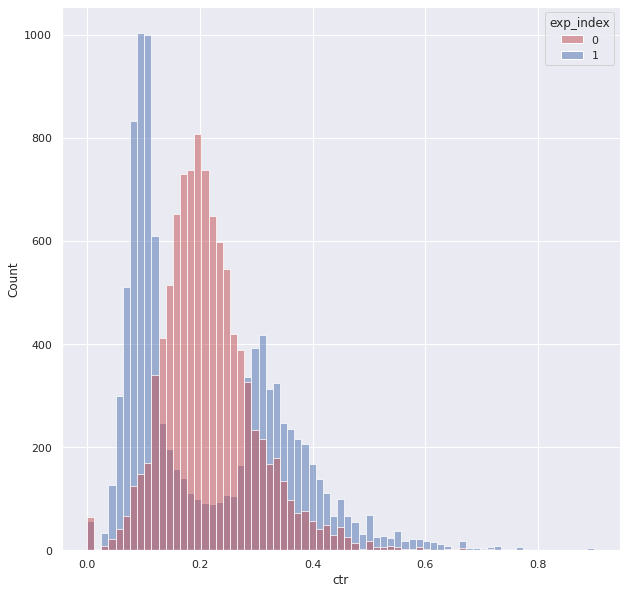

In [15]:
#Посмотрим на гистограмму распределения CTR
sns.set(rc={'figure.figsize':(10,10)})

groups = sns.histplot(data = df_ab, 
              x='ctr', 
              hue='exp_index', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [16]:
#Оценивая визуально можно сказать что:
#1-Выборки не являются статистически эквивалентными
#2-В тестовой группе обнаруживается два пика, иными словами оно бимодальное и состоит из двух отдельных групп пользователей.
#3-При условии того, что система сплитования работает корректно такой результат может говорить о том, что пользователи разделились на две группы в ответ на нововведение.
#4-дальнейшая работа и наблюдение за этими подруппами может дать лучшее понимание конечного пользователя и того, в каком направлении надо двигаться в развитии продукта.

In [17]:
#Сохраним наши группы в переменные
group_0 = df_ab[df_ab.exp_index==0].ctr
group_1 = df_ab[df_ab.exp_index==1].ctr

In [18]:
#Проведем тест Стьюдента
stats.ttest_ind(group_0,
                group_1,
                equal_var=False)

Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

In [19]:
#Результат p-value сильно больше чем 0,05 что ложно говорит нам о том что эти группы статистически эквивалентны.
#Считать такой результат приемлемым нельзя, т.к. тестовое распределение не обладает свойствами нормального.
#Получается такой результат это из-за того вычисленное среднее значение тестовой группы близко к контрольному.

In [20]:
#Проведем тест Манна-Уитни
stats.mannwhitneyu(group_0, group_1)

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [21]:
#p-value после подсчета теста Манна-Уитни <0.05 говорит нам о том что эти группы имеют статистическое различие
#между друг другом. 
#Тест Манна-Уитни подходит для обсчета не нормалтных распределений, но все равно не дает право 
#говорить о заключении выбора в gользу нового алгоритма

In [69]:
#Проведем t-test на сглаженом CTR. 
#Для этого, напишем функцию сглаживания

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

#Гиперпараметр альфа по условию равен 5
alpha=5

#Посчитаем общий CTR для каждой из групп
global_ctr_0 = df_ab[df_ab.exp_index == 0].likes.sum()/df_ab[df_ab.exp_index == 0].views.sum()
global_ctr_1 = df_ab[df_ab.exp_index == 1].likes.sum()/df_ab[df_ab.exp_index == 1].views.sum()

#Добавим в дс колонки с общим CTR, и сглаженым CTR 
df_ab['global_ctr'] = df_ab['exp_index'].apply(lambda x: global_ctr_0  if x==0 else global_ctr_1)
df_ab['smothed_ctr'] = get_smothed_ctr(df_ab.likes,df_ab.views,df_ab.global_ctr,alpha)

#Посмотрим на первые 5 результатов датасета
df_ab.head()

,user_id,exp_index,likes,views,ctr,global_ctr,smothed_ctr
0,4660,0,15,69,0.217391,0.209604,0.216865
1,4742,0,10,31,0.322581,0.209604,0.306889
2,138058,1,4,65,0.061538,0.200251,0.071446
3,26579,1,27,63,0.428571,0.200251,0.411783
4,129283,0,9,50,0.180000,0.209604,0.182691


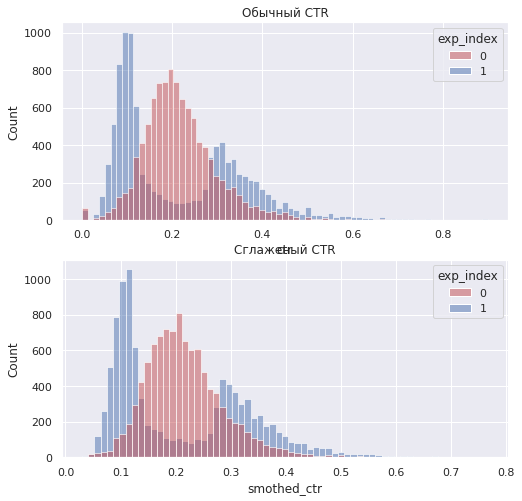

In [113]:
#Сравним визуально распределение обычных и сглаженых CTR
fig,ax =plt.subplots(2,1,figsize=(8, 8))
sns.histplot(df_ab ,
             ax=ax[0],
              x='ctr', 
              hue='exp_index', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False).set( title="Обычный CTR")

sns.histplot(df_ab,
             ax=ax[1], 
              x='smothed_ctr', 
              hue='exp_index', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False).set( title="Сглаженый CTR")
plt.show()

In [114]:
#Визуально график стал более гладкий, без выбросов.

In [116]:
#Проведем тест Стьюдента
stats.ttest_ind(df_ab[df_ab.exp_index==0].smothed_ctr,
                df_ab[df_ab.exp_index==1].smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027292, pvalue=0.051666790153189965)

In [117]:
#p-value в сглаженном тесте Стьюдента приблизился к значению статистической разницы. 
#Но все равно мы не можем использовать этот тест из за ненормальности распределения.

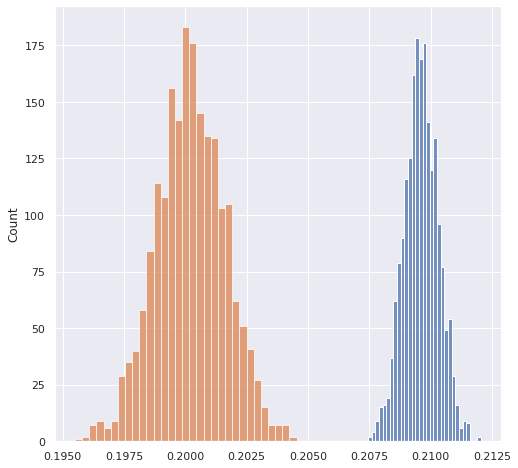

In [130]:
#Применим функцию Пуассоновского бутстрепа. что бы получить общий CTR из псевдо-генеральных выборок наших групп.
#Для этого напишем фукнцию
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2



likes1 = df_ab[df_ab.exp_index == 0].likes.to_numpy()
views1 = df_ab[df_ab.exp_index == 0].views.to_numpy()
likes2 = df_ab[df_ab.exp_index == 1].likes.to_numpy()
views2 = df_ab[df_ab.exp_index == 1].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

#Визуальзируем графики
sns.set(rc={'figure.figsize':(8,8)})
sns.histplot(ctr1)
sns.histplot(ctr2)
plt.show()

In [131]:
#Как мы можем наблюдать распределения CTR даже не имеют пересечений, соответственно не являются статистически эквивалентными.
#Пуассоновский бутстреп так же можно применять практически при любом распределении.

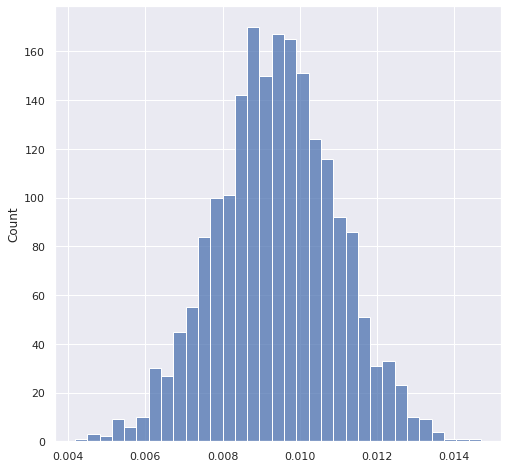

In [129]:
#Разница между глобальными CTR
sns.set(rc={'figure.figsize':(8,8)})
sns.histplot(ctr1 - ctr2)
plt.show()

In [134]:
#Бакетное преобразование. Разделим наши группы на 50 частей в каждой, и посчитаем групповой CTR(CTR метабользователя)
#И 0,9 квантиль CTR метапользователя
#И после этого пременем тест Манна-Уитни и тесть Стьюдента для оценки
q = """

SELECT case when exp_group = 1 then 0 else 1 end as exp_index, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20230920.feed_actions  
    WHERE toDate(time) BETWEEN '2023-08-29' AND '2023-09-04' AND exp_group IN (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_index == 0].bucket_ctr, 
                   df[df.exp_index == 1].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [135]:
#Бакетное преобразование с тестом Манна-Уитни так же показала статистическое различие в группах

In [136]:
#и t-тест тоже
stats.ttest_ind(df[df.exp_index == 0].bucket_ctr, 
                   df[df.exp_index == 1].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

In [137]:
#Бакетное преобразование улучшило t-test и теперь он показывает статистическое различие в группах

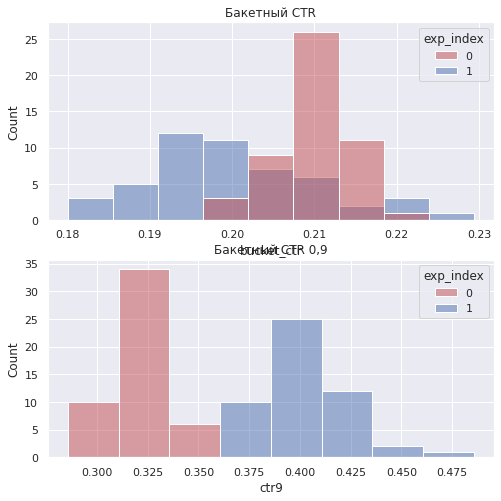

In [145]:
fig,ax =plt.subplots(2,1,figsize=(8, 8))
sns.histplot(df ,
             ax=ax[0],
              x='bucket_ctr', 
              hue='exp_index', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False).set( title="Бакетный CTR")

sns.histplot(df,
             ax=ax[1], 
              x='ctr9', 
              hue='exp_index', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False).set( title="Бакетный CTR 0,9")
plt.show()


In [146]:
#Различия в распределениях видно невооруженным взглядом

Вывод

Сравнивая различные методики A\B-тестирования можно утверждать, что конкретно для нашего бимодильного распределения тестовой группы подходят: Пуассоновский бутстреп, тест Манна-Уитни, а также t-тест и тест Манна-Уитни поверх бакетного преобразования. Они дают представления о том что наши распределения являются статистически различными. 
Обычны t-тест и t-тест на сглаженном ctr (α=5) из за метода зависимого от среднего значения и дисперсии, не показывает статистического различия между нашими группами.

Оценивая визуально можно сказать что:
#1-Выборки не являются статистически эквивалентными
#2-В тестовой группе обнаруживается два пика, иными словами оно бимодальное и состоит из двух отдельных групп пользователей.
#3-При условии того, что система сплитования работает корректно такой результат может говорить о том, что пользователи разделились на две группы в ответ на нововведение.
#4-дальнейшая работа и наблюдение за этими подруппами может дать лучшее понимание конечного пользователя и того, в каком направлении надо двигаться в развитии продукта.

Вывод по поводу принятия нового алгоритма: четкого положительного отклика у пользователей не наблюдается. Необходимо продолжить дальнейшую работу над ним. А так же проанализировать пользователей тестовой группы, определить почему клиенты разделились на дву группы (с повышением и с уменьшением CTR). Если возможно, учесть  недостатки данного алгоритма и постараться, если не исключить, то хотя бы минимизировать негативное его внияние на некоторые группы пользователей у которых снизился CTR.